### Feature Engineering vs Feature Learning

source: https://www.youtube.com/watch?v=WElBhXr9B7c (DigitalSreeni)

Here I just want to implement what i've learnt from the video above.

### Feature Engineering

> importing libraries

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

> settings the feature engineering kernel properties

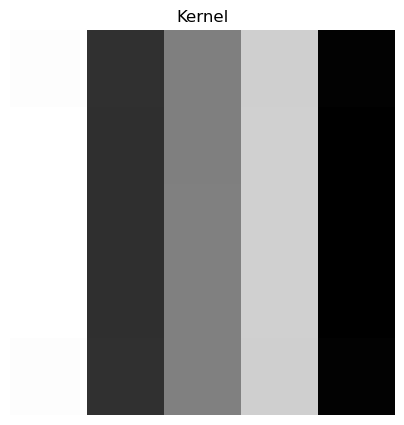

In [21]:
kernel_size_ = 5
sigma_ = 5
theta_ = 1 * np.pi / 1.
lambda_ = 1 * np.pi / 5
gamma_ = .5
phi_ = np.pi / 2

kernel = cv2.getGaborKernel((kernel_size_, kernel_size_), sigma_, theta_, lambda_, gamma_, phi_)

fig, axs = plt.subplots(1, 1, figsize=(5, 5))

axs.imshow(kernel, cmap="gray")
axs.title.set_text('Kernel')
axs.axis('off')

plt.show()


> applied to our image

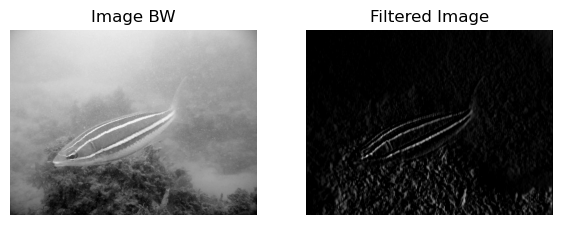

In [19]:
image = cv2.imread('image.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
filtered_image = cv2.filter2D(image, cv2.CV_8UC3, kernel)

fig, axs = plt.subplots(1, 2, figsize=(7, 7))

axs[0].imshow(image, cmap='gray')
axs[0].title.set_text('Image BW')
axs[0].axis('off')

axs[1].imshow(filtered_image, cmap='gray')
axs[1].title.set_text('Filtered Image')
axs[1].axis('off')

plt.show()

> try to change our `kernel_size_` variable to 7, and `thetha` to 90, then apply it again to our image

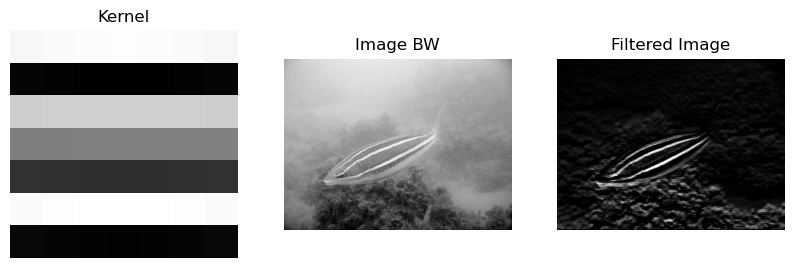

In [33]:
kernel_size_ = 7
sigma_ = 5
theta_ = 1 * np.pi / 2.
lambda_ = 1 * np.pi / 5
gamma_ = .5
phi_ = np.pi / 2
kernel = cv2.getGaborKernel((kernel_size_, kernel_size_), sigma_, theta_, lambda_, gamma_, phi_)

filtered_image = cv2.filter2D(image, cv2.CV_8UC3, kernel)

fig, axs = plt.subplots(1, 3, figsize=(10, 10))

axs[0].imshow(kernel, cmap='gray')
axs[0].title.set_text('Kernel')
axs[0].axis('off')

axs[1].imshow(image, cmap='gray')
axs[1].title.set_text('Image BW')
axs[1].axis('off')

axs[2].imshow(filtered_image, cmap='gray')
axs[2].title.set_text('Filtered Image')
axs[2].axis('off')

plt.show()

> as you can see, the feature engineering method needs a lot of trial and error experiments, changing the value of kernel's properties to get the best result. Therefore, feature learning is the best solution.

### Feature Learning

> we are using VGG16 to extract the feature map of our image

In [34]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16

> load our model

In [35]:
model = VGG16(weights="imagenet")
print(model.summary())

553467096/553467096 [==============================] - 173s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                          

> test to get layer 1 data

In [49]:
layer = model.layers
filters, biases = layer[1].get_weights()
print(layer[1].name, filters.shape)

block1_conv1 (3, 3, 3, 64)


> plot filters from `layer 1`, because our the number of filters of `block1_conv1` is `64`

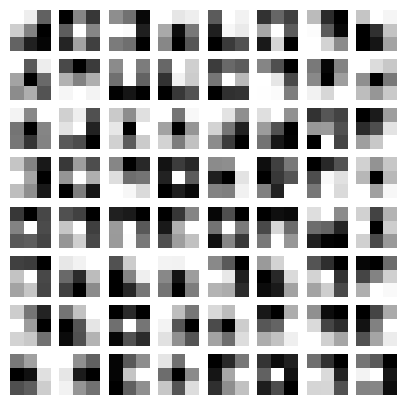

In [124]:
cols = rows = 8
fig, axs = plt.subplots(rows, cols, figsize=(5, 5))

for r in range(0, rows):
    for c in range(0, cols):
        filter = filters[:, :, :, cols*r+c]
        axs[r][c].imshow(filter[:, :, 0], cmap='gray')
        axs[r][c].axis('off')
plt.show()

> Now plot the filters output

In [74]:
conv_layer_index = [1, 3, 6] # conv layers of interest 1 to 3, then 3 to 6 as the output
outputs = [model.layers[i].output for i in conv_layer_index]
model_short = Model(inputs=model.inputs, outputs=outputs)
print(model_short.summary())

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [77]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

image = load_img('image.jpg', target_size=(224, 224)) # VGG16 input shape 224
image = img_to_array(image) # shape (224, 224, 3)
image = np.expand_dims(image, axis=0) # shape (1, 224, 224, 3), then we can input this shape format to our model

feature_output = model_short.predict(image)

1/1 [==============================] - 0s 313ms/step


> plot our outputs

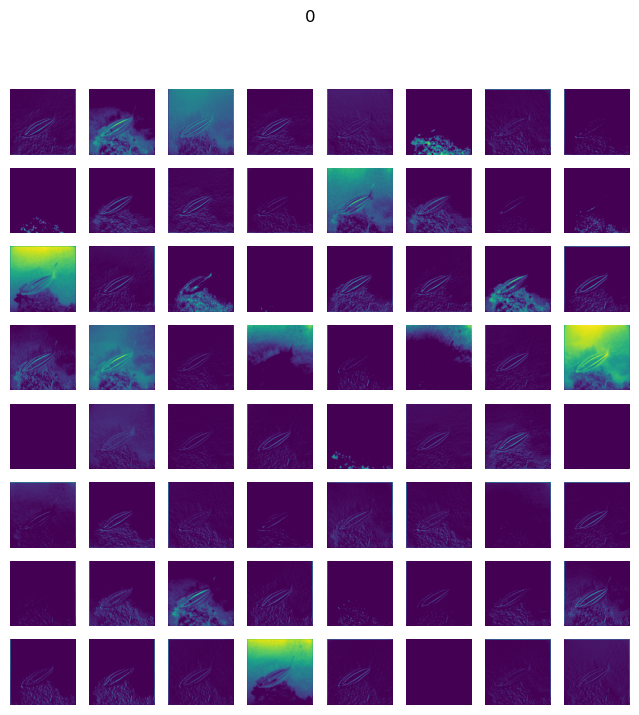

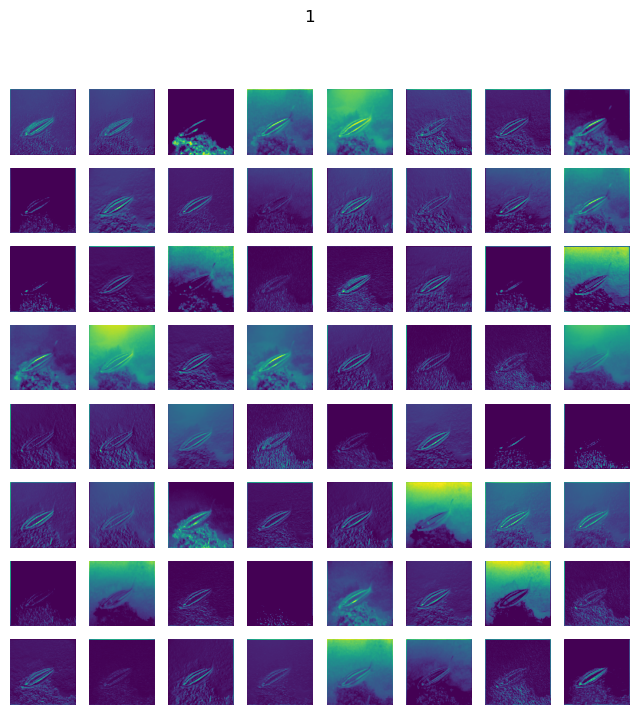

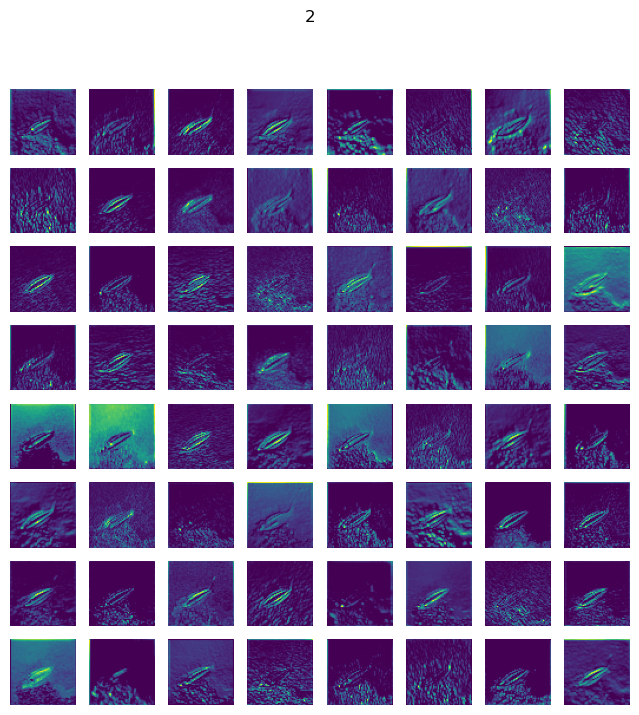

In [123]:
plt.rcParams['font.size'] = 10

for feature_i, feature in enumerate(feature_output):

    cols = rows = 8
    fig, axs = plt.subplots(rows, cols, figsize=(8, 8))

    for r in range(rows):
        for c in range(cols):
            channel = cols*r+c

            # axs[r][c].set_title(feature_i)
            axs[r][c].imshow(feature[0, :, :, channel])
            axs[r][c].axis('off')
    fig.suptitle(feature_i)
    plt.show()

> as we can see, the more deeper the layer, the feature map get more better representation of the input image too.